# Make more is a Character-Level language Model

- Takes Names as example
- Within each example, learning the sequence of characters in the name
- Learning the probability of the next character given the previous characters

#### We will build:

1. Bigram -> Always just look at the previous character to predict the next

later:

- Bag of Words
- MLP, along the lines of Bengio et al. (2003)
- RNN, along the lines of Sutskever et al. (2011)
- GRU, following Kyunghyun Cho et al. (2014)
- Transformer, following Vaswani et al. (2017)


In [1]:
words = open('names.txt').read().splitlines()
words = [word.lower() for word in words] # they should be already lowercase, but just in case
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
print(f"Training Data size: {len(words)}")
print(f"shortest name: {min(words, key=len)}, length: {len(min(words, key=len))}")
print(f"longest name: {max(words, key=len)}, length: {len(max(words, key=len))}")

Training Data size: 32033
shortest name: an, length: 2
longest name: muhammadibrahim, length: 15


### Introducing special character marking first and last character

- When creating the bigram model, we need to introduce a starting and ending character
- We can use the same special character for both, as long as it is not in the dataset
- Let's use '.' (it's beautiful in the chart below)


In [3]:
def create_bigram(words, log=False):
  b = {}
  for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
      bigram = (ch1, ch2)
      b[bigram] = b.get(bigram, 0) + 1
      if log:
        print(ch1, ch2)
  if log:
    print(b)
  return b

create_bigram(words[:3], log=True)
b = create_bigram(words)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .
{('.', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '.'): 3, ('.', 'o'): 1, ('o', 'l'): 1, ('l', 'i'): 1, ('i', 'v'): 1, ('v', 'i'): 1, ('i', 'a'): 1, ('.', 'a'): 1, ('a', 'v'): 1, ('v', 'a'): 1}


In [4]:
sorted(b.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

### Let's use pytorch to store probabilities in a 2D tensor (Matrix)

In [5]:
import torch

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Now instead of dictionary, we can use the matrix to store probabilities

In [7]:
N = torch.zeros((27, 27), dtype=torch.int32)
for w in words:
  w = '.' + w + '.'
  for ch1, ch2 in zip(w, w[1:]):
    idx1, idx2 = stoi[ch1], stoi[ch2]
    N[idx1, idx2] += 1

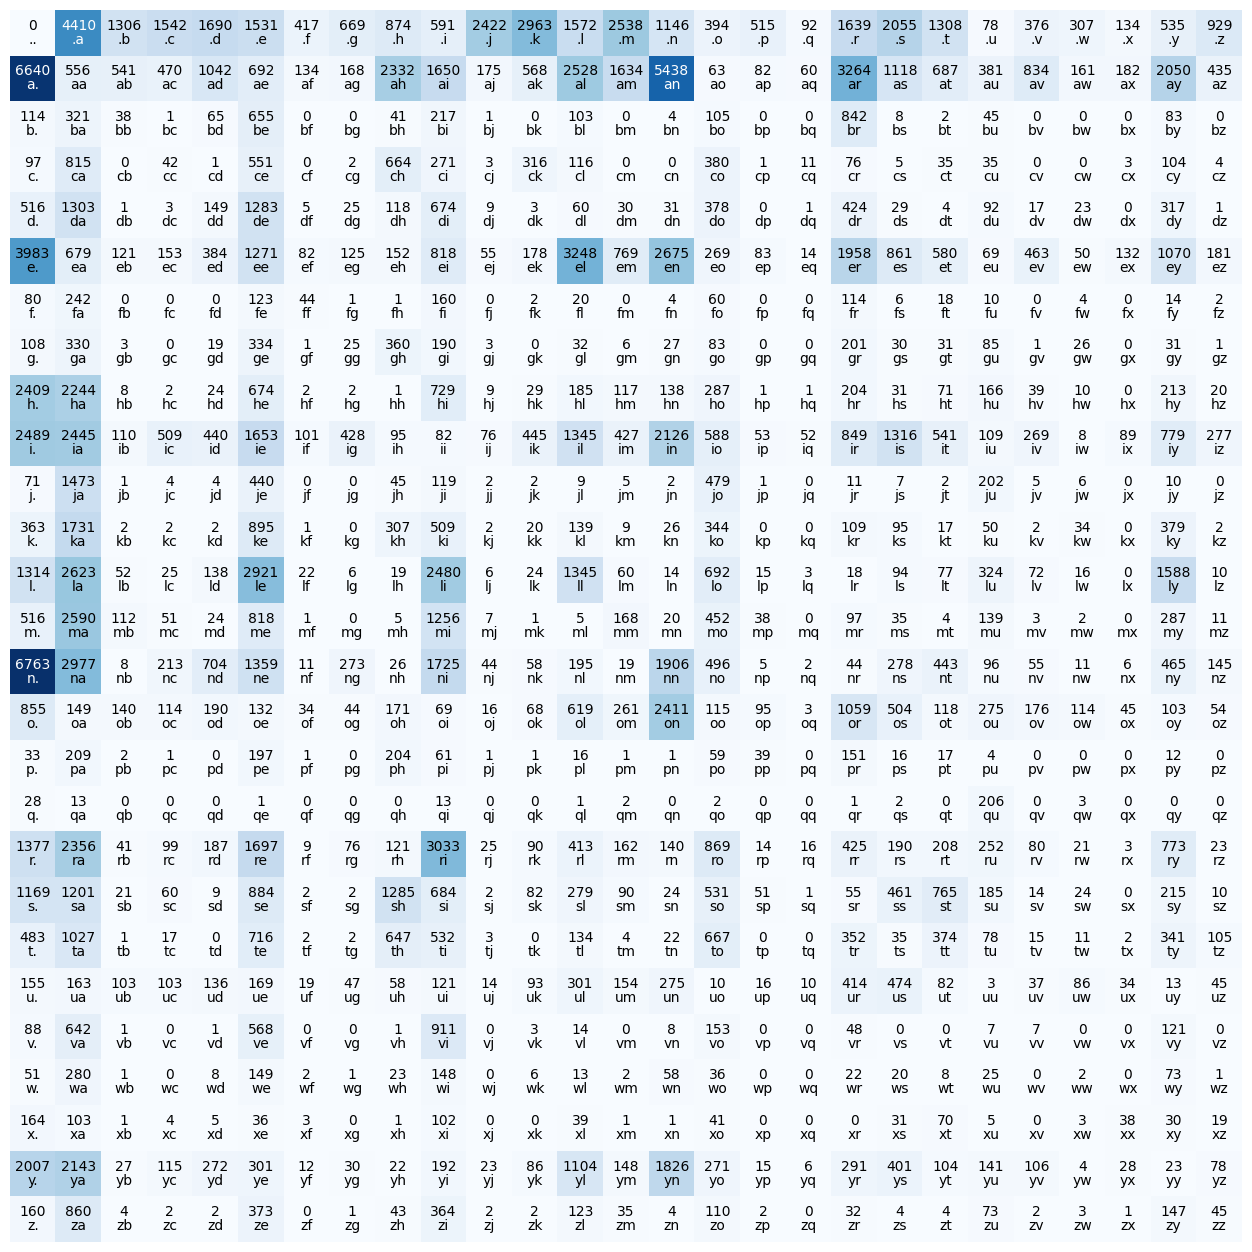

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_bigram_distr(N, itos):

  plt.figure(figsize=(16, 16))
  plt.imshow(N, cmap="Blues", interpolation='nearest')
  
  max_v = N.max().item()
  bw_threshold = 0.6
  
  # insert lables
  for i in range(27):
    for j in range(27):
      value = N[i, j].item()
      # if value is a float < 1 show percentage
      if isinstance(value, float) and value < 1:
        v = f"{value:.0%}"
      else:
        v = round(value)
      color = 'white' if value > bw_threshold * max_v else 'black'
      plt.text(j, i, v, ha='center', va='bottom', color=color)
      plt.text(j, i, itos[i] + itos[j], ha='center', va='top', color=color)
  plt.axis('off');
  
plot_bigram_distr(N, itos)

In [9]:
# Let's get the probability for a character to be the first of the word.

# Following charachter '.'

p = N[stoi['.']].float() / N[stoi['.']].sum()	



In [10]:
# Let's get some random stuff

g = torch.Generator().manual_seed(42)
p = torch.rand(3, generator=g)
print("3 random numbers:", p)
print("normalized:", p / p.sum())
print("20 random samples:", torch.multinomial(p, 20, replacement=True, generator=g))

3 random numbers: tensor([0.8823, 0.9150, 0.3829])
normalized: tensor([0.4047, 0.4197, 0.1756])
20 random samples: tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2])


In [11]:
# let's use our bigram probabilities...
g = torch.Generator().manual_seed(43)
p = N[stoi['.']].float() / N[stoi['.']].sum()
draws = torch.multinomial(p, 5, replacement=True, generator=g)
print("5 random draws:", draws)
print("5 random chars:", [itos[i.item()] for i in draws])

5 random draws: tensor([13,  8,  3, 14, 26])
5 random chars: ['m', 'h', 'c', 'n', 'z']


In [12]:
# let's generate a name
g = torch.Generator().manual_seed(42)

for i in range(10):
    name = []
    ch = '.'
    while True:
        p = N[stoi[ch]].float() / N[stoi[ch]].sum()
        ch = itos[torch.multinomial(p, 1, replacement=True, generator=g).item()]
        if ch == '.':
            break
        name.append(ch)
    print(''.join(name))

ya
syahavilin
dleekahmangonya
tryahe
chen
ena
da
amiiae
a
keles


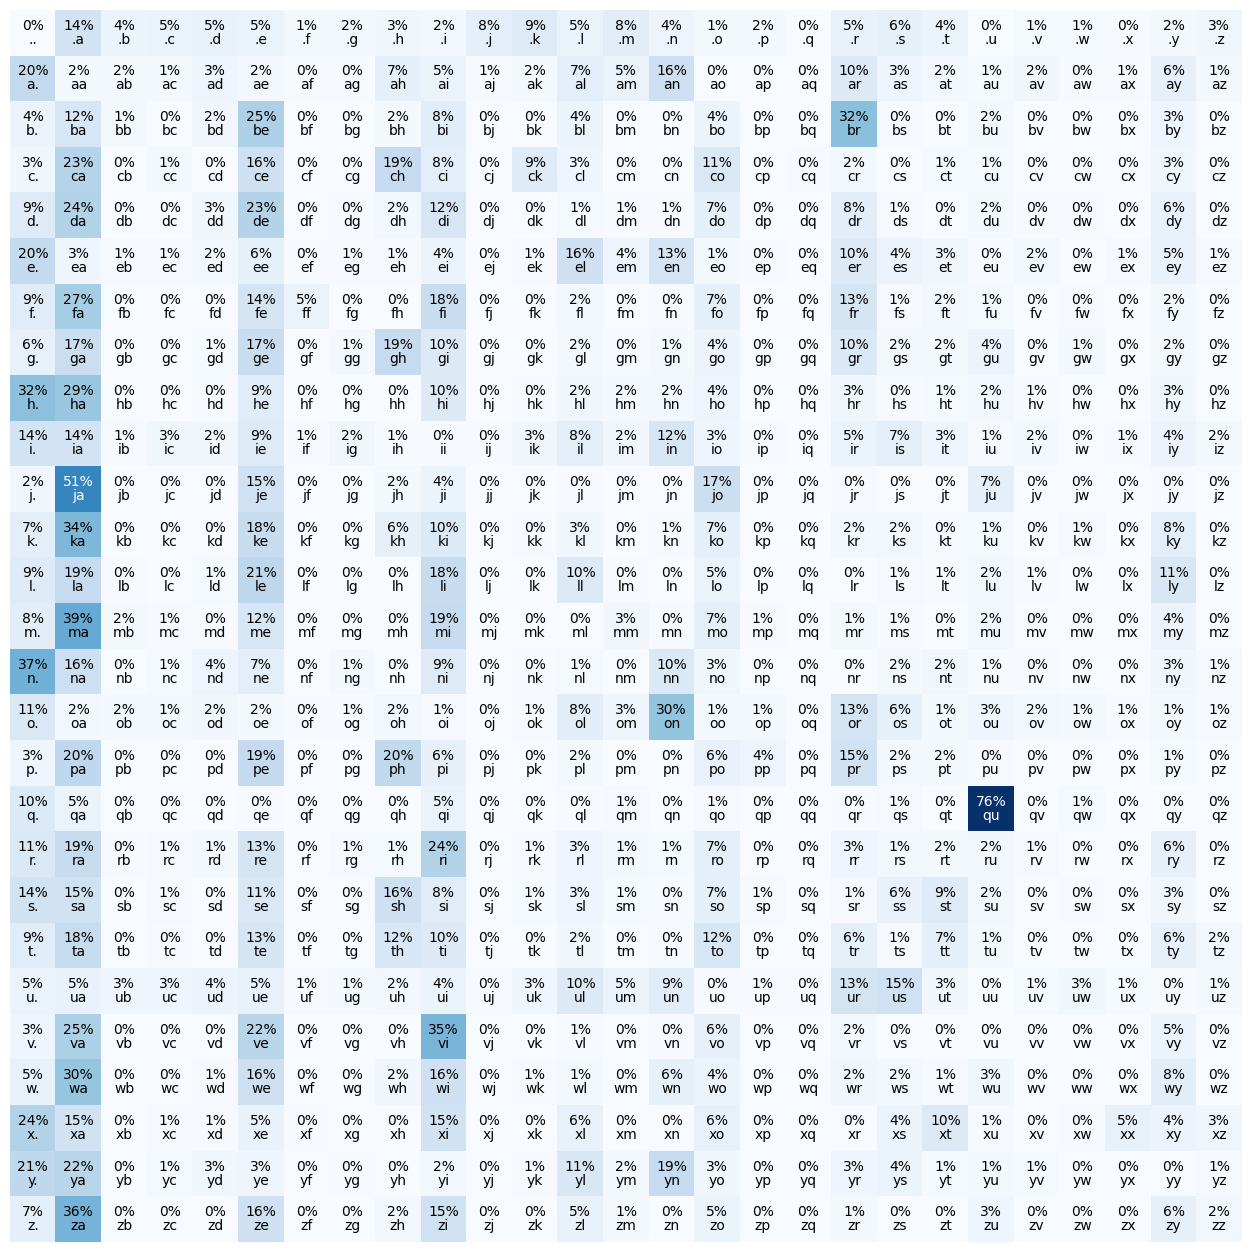

In [13]:
# fix inefficieny

# calculate the probabilities once and not all the time
# use Torch's advanced sum function to sum along the row

    
P = N.float() / N.sum(dim=1, keepdim=True)
plot_bigram_distr(P, itos)

In [14]:
def generate_names(N, itos, stoi, g=None, n=10):
    P = N.float() / N.sum(dim=1, keepdim=True)
    
    names = []
    for i in range(n):
        name = []
        idx = 0
        while True:
            p = P[idx]
            idx = torch.multinomial(p, 1, replacement=True, generator=g).item()
            if idx == 0:
                break
            ch = itos[idx]
            name.append(ch)
        names.append(''.join(name))
    return names

g = torch.Generator().manual_seed(42)
generate_names(N, itos, stoi, g)

['ya',
 'syahavilin',
 'dleekahmangonya',
 'tryahe',
 'chen',
 'ena',
 'da',
 'amiiae',
 'a',
 'keles']

## Check if the actual words from dataset have a high likelihood of being generated by the model

In [15]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [30]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["andrej"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-744470.2500, grad_fn=<AddBackward0>)
nll=tensor(744470.2500, grad_fn=<NegBackward0>)
3.2631309032440186


: 

In [17]:
# we would want to minimize the negative log likelihood in the future when we improve the model

### Same Bigram Approach in a gradient-based training setting

- should not perform better than the simple bigram model
- but offers more flexibility for future model extensions
- and is a good starting point for learning about PyTorch

In [18]:
# Emma example
xs = torch.tensor([ 0,  5, 13, 13,  1])
ys = torch.tensor([ 5, 13, 13,  1,  0])

In [19]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([5, 27])

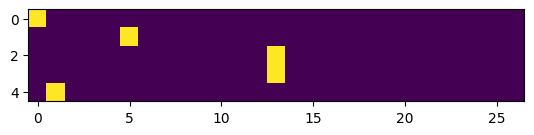

In [20]:
plt.imshow(xenc)

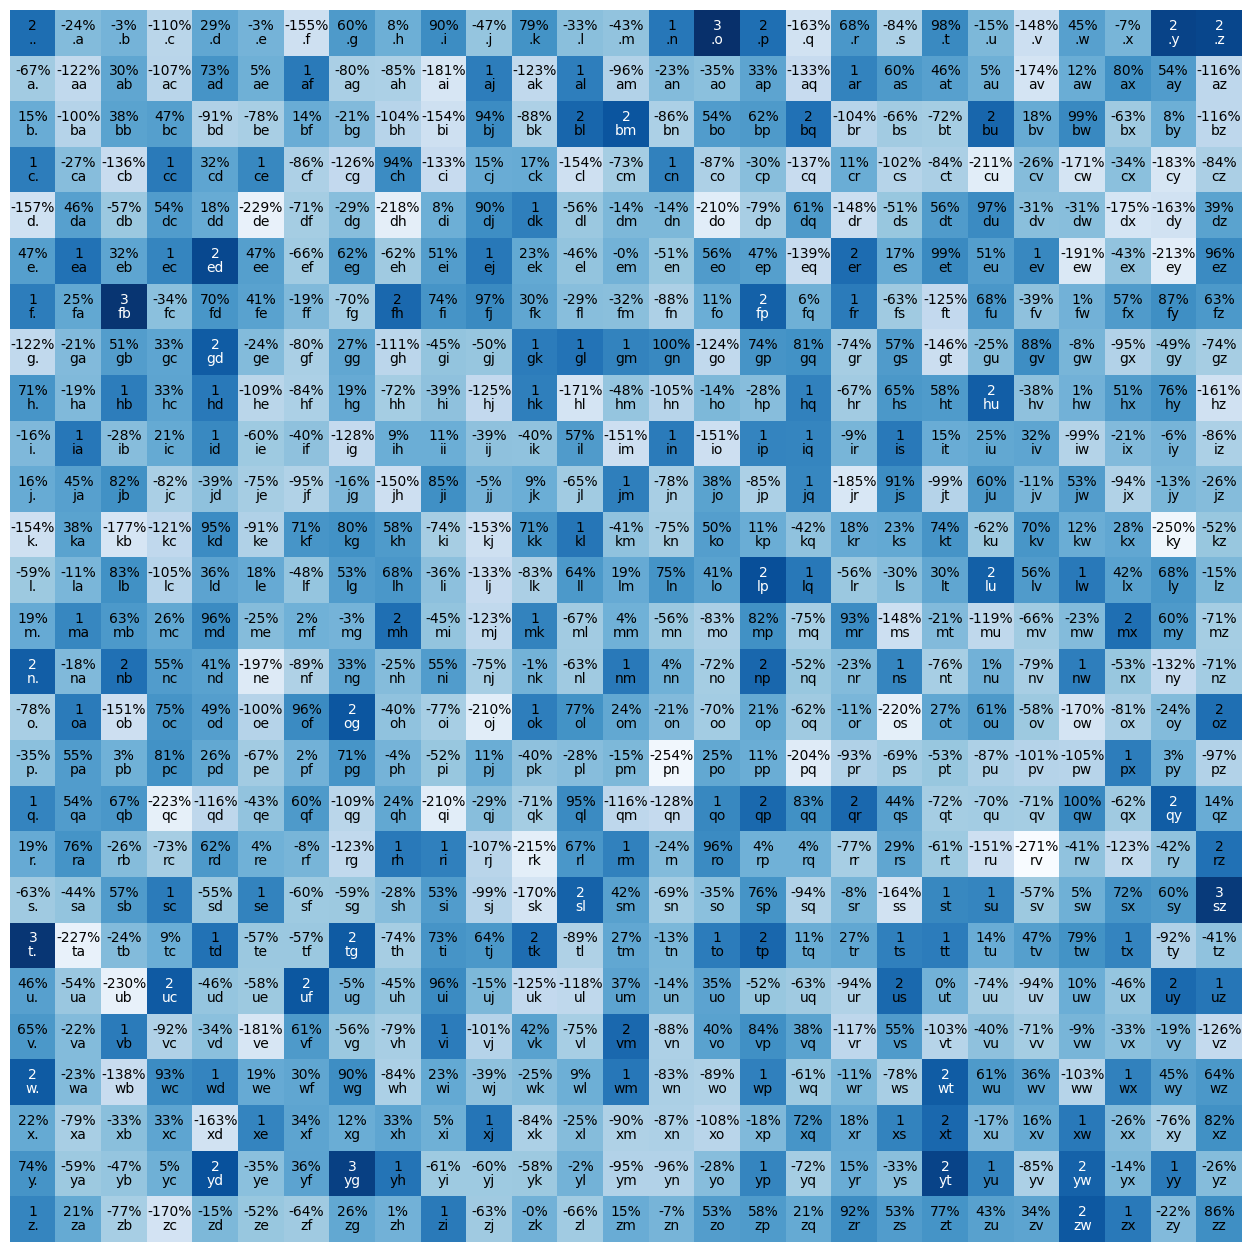

In [21]:
# initial probabilities
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True ,generator=g)
plot_bigram_distr(W.detach(), itos)

In [22]:
# Emma example
print(f"input: {xs=}")
print(f"expected next char: {ys=}")

input: xs=tensor([ 0,  5, 13, 13,  1])
expected next char: ys=tensor([ 5, 13, 13,  1,  0])


In [23]:
logits = xenc @ W # pop out the "probabilities" from random weights, log-couunts
counts = logits.exp() # converted to counts
probs = counts / counts.sum(dim=1, keepdims=True) # normalized to probabilities
print(f"{probs.shape=}")
print("\n")
print("Probabilities for follow up on first char:")
probs[0]

probs.shape=torch.Size([5, 27])


Probabilities for follow up on first char:


tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)

In [24]:
# probs has for each test case the probability of all 27 possible next characters,
# let's see what the probabilities were that the model assigned to the correct next character

print(probs[torch.arange(len(xs)), ys])
loss = -probs[torch.arange(len(xs)), ys].log().mean()
loss.item()

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)


3.7693049907684326

In [25]:
# let's do it for all words
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    xs.append(stoi[ch1])
    ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print('number of bigrams:', len(xs))

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True, generator=g)

number of bigrams: 228146


In [26]:
def forward(W, xs, ys):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    return probs
    
def get_loss(probs, ys):
    loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean()
    return loss

In [27]:
def backward(loss):
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad # andrej tested already smaller learning rate but it was too slow

In [28]:
iterations = 200
for i in range(iterations):
    probs = forward(W, xs, ys)
    loss = get_loss(probs, ys)
    # every 10% of the iterations print the loss
    if i % (iterations // 10) == 0:
        print(f'{i=}, {loss.item()=}')
    backward(loss)

i=0, loss.item()=3.7686190605163574
i=20, loss.item()=2.5822560787200928
i=40, loss.item()=2.521263837814331
i=60, loss.item()=2.5027060508728027
i=80, loss.item()=2.494438409805298
i=100, loss.item()=2.4899587631225586
i=120, loss.item()=2.4872729778289795
i=140, loss.item()=2.485551357269287
i=160, loss.item()=2.484389066696167
i=180, loss.item()=2.4835691452026367


In [29]:
# We are approaching the same "quality" as the explicit use of the bigram probabilities
# through counting

# let's generate some names

P = forward(W, xs, ys)

names = generate_names(P, itos, stoi)
print(names)

['nx', 'jaaea', 'ciaygiygua', 'cmd', 'ask', 'dnarlm', 'slpjreh', 'a', 'sniiriohyd', 'neniiityjnycpkiiij']
